<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/lab5/pi_exercises5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

In [16]:
#exercise 1

input_size = 2
hidden_size = 4
num_layers = 1
rnn_layer = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

seq_length = 5
batch_size = 1
input_data = torch.randn(seq_length, batch_size, input_size) # (5, 1, 2)

initial_hidden_state = torch.randn(num_layers, batch_size, hidden_size)  # (1, 1, 4)

output, hidden_state = rnn_layer(input_data, initial_hidden_state)

print("Output:", output)
print("New Hidden State:", hidden_state)

Output: tensor([[[ 0.8687, -0.3479, -0.2751, -0.1099]],

        [[ 0.0536,  0.0534, -0.6131,  0.2091]],

        [[ 0.6769,  0.5871, -0.2059,  0.5038]],

        [[ 0.4106, -0.1400, -0.6041,  0.2808]],

        [[ 0.3570,  0.3508, -0.5552,  0.5333]]], grad_fn=<StackBackward0>)
New Hidden State: tensor([[[ 0.3570,  0.3508, -0.5552,  0.5333]]], grad_fn=<StackBackward0>)


In [26]:
# exercise 2

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [27]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [28]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In [32]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [30]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [41]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 20, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')

    return perplexities

In [42]:
batch_size, num_steps = 30, 10
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

num_hiddens = 32
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers=2)

device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs, lr = 200, 1.5
perplexities = train(net, train_iter, vocab, lr, num_epochs, device)

time traveller a sour a sour a sou
time traveller this to light the t
time traveller a mome traveller th
time traveller and the time the ti
time traveller the time the time t
time traveller the said the said t
time traveller a liment of space a
time traveller the time traveller 
time traveller the said the this n
time traveller the time travel in 
time traveller think and and and a
time traveller the said the said t
time traveller a line a line a lin
time traveller and and and and and
time traveller the said the said t
time traveller and the said the so
time traveller said the some trave
time traveller and the said the sa
time traveller the to a moment a m
time traveller so a limproperanis 
perplexity 5.2, device cpu


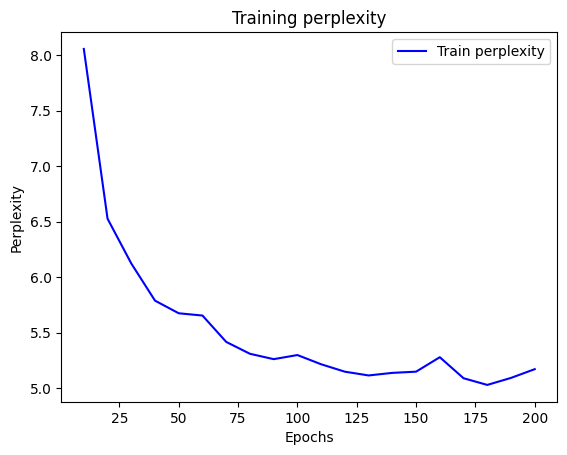

In [43]:
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity')
    plt.title('Training perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()

plot_perplexity(perplexities)

In [44]:
# exercise 3

def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('time', 35, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')

    return perplexities

In [45]:
vocab_size, num_hiddens, device = len(vocab), 16, try_gpu()
num_epochs, lr = 300, 3
batch_size, num_steps = 50, 15

train_iter, vocab = load_data_time_machine(batch_size, num_steps)

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens, num_layers=3)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device)

predict('time', 35, net, vocab, device)

time a a a a a a a a a a a a a a a a a 
time the the the the the the the the th
time and the the the the the the the th
time the spas an the spas an the spas a
time thas han the thas han the thas han
time the travelle the travelle the trav
time to the this the this the this the 
time and the traveller and the travelle
time the time traveller and the pericta
time traveller there int of the travell
time the this shold the traveller the t
time traveller the traveller shame ther
time that shand that shand that shand t
time that shaven the traveller and the 
time that and the preolly the medical m
time the this shame fire the travel the
time thing thase that and thas and ther
time traveller said the pater that and 
time think the prove and the prove and 
time traveller shour dimension and the 
time there in and the pare and the pare
time thang mave and the people travelle
time the persice the lond the traveller
time the time traveller said the preons
time that said the traveller thing thas


'time timer the time traveller so a limp'

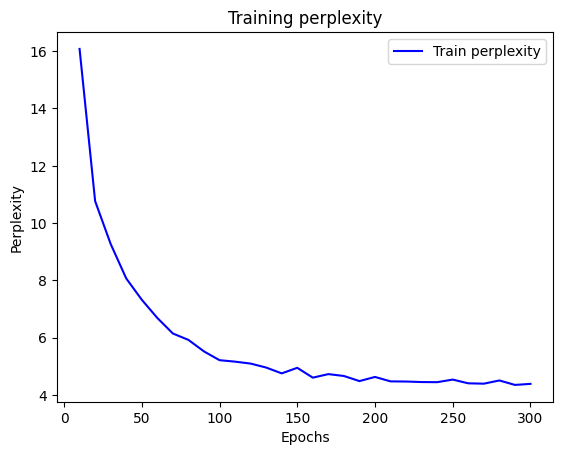

In [46]:
plot_perplexity(perplexities)